# Week 3: Testing 5 Different Approaches

## 1. Setting the Stage

In our last meeting on XX-XX-XXXX we talked about 5 methods for getting the structure of a company. Here you will find all 5 methods displayed along with their interpretations and explanations on how to run these on your own for further testing.

1. Finding a hierarchy through words such as `"reports to"`, `"supervised by"`, `"supervises"`, and others.

2. Job Titles found in different job descriptions and whether the job description points to, or mentions a, higher/lower level role. This includes network analysis.

3. Skills found at each level (e.g., low, mid, high) and/or job description. This includes network analysis.

4. Geographical differences between position levels. Are there higher level roles within a specific geographical region.

5. Split by product/service/other categories, and then cluster the roles within a category. The idea is that this could be similar to how a company splits its divisions, for example, Amazon with AWS, Alexa, Online marketplace, etc.

6. Additonal Step: Recreate visualisation from _"An Open and Data-driven Taxonomy of Skills Extracted from Online Job Adverts."_ by Jyldyz Djumalieva and Catch Sleeman.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
from glob import glob # This package helps us grab multiple files with similar conventions using a wildcard.
import os
import nltk
from pprint import pprint

# Pandas by default won't show too many variables so in order to work around
# this, we set up the following option
pd.set_option('display.max_columns', None) 

%matplotlib inline

In [2]:
# notice the wildcard * capturing all datasets in your folder "x_companies*.csv"
files = glob('/Users/ramonperez/Dropbox/Burning Glass/Analysis/company_data/x_companies_*.csv') 

# Create a list containing all of the datasets
dfs = [pd.read_csv(f, low_memory=False, parse_dates=['JobDate']) for f in files]

# Concatenate all of the datasets into one
df = pd.concat(dfs)

In [45]:
df.head(15)

,BGTOcc,BGTSubOcc,CIPCode,CanonCertification,CanonCity,CanonCountry,CanonCounty,CanonEmployer,CanonIntermediary,CanonJobHours,CanonJobTitle,CanonJobType,CanonMaximumDegree,CanonMinimumDegree,CanonOtherDegrees,CanonPostalCode,CanonPreferredDegrees,CanonRequiredDegrees,CanonSkillClusters,CanonSkills,CanonState,CanonYearsOfExperienceCanonLevel,CanonYearsOfExperienceLevel,CleanJobTitle,ConsolidatedDegreeLevels,ConsolidatedInferredNAICS,ConsolidatedONET,ConsolidatedTitle,DivisionCode,Email,InternshipFlag,IsDuplicate,IsDuplicateOf,JobDate,JobDomain,JobID,JobReferenceID,JobText,JobURL,LMA,Language,Latitude,Longitude,MSA,MaxAnnualSalary,MaxDegreeLevel,MaxExperience,MaxHourlySalary,MinAnnualSalary,MinDegreeLevel,MinExperience,MinHourlySalary,PostingHTML,Source,StandardMajor,Telephone,YearsOfExperience
0,41-2031.00,Retail Sales Associate (General),NaN,\n,Foley,USA,Baldwin,Chrysler,NaN,fulltime,Sales Associate,permanent,NaN,NaN,NaN,36535,NaN,NaN,Sales: Specialized Sales;Specialized Skills|Sp...,{'Automotive Sales': 'Sales: Specialized Sales...,AL,NaN,NaN,Sales Associate,NaN,336111.0,41203100,Sales Associate,NaN,NaN,0,False,NaN,2017-03-25,www.ziprecruiter.com,38201188919,NaN,"Sales Associates\n-Foley,AL36535\n-3781 S McKe...",https://www.ziprecruiter.com/jobs/gulf-chrysle...,MC011930,en,30.3962,-87.7019,19300: Metropolitan Statistical Area,100000.0,NaN,NaN,48.08,100000.0,NaN,NaN,48.08,NaN,Job Board,NaN,NaN,NaN
1,41-2031.00,Retail Sales Associate (General),NaN,\n,Foley,USA,Baldwin,Chrysler,NaN,fulltime,Sales Associate,permanent,NaN,Higher Secondary Certificate,NaN,36535,NaN,Higher Secondary Certificate,Sales: Specialized Sales;Specialized Skills|Co...,{'Automotive Sales': 'Sales: Specialized Sales...,AL,NaN,NaN,Automotive Sales Associate,12,336111.0,41203100,Sales Associate,NaN,NaN,0,False,NaN,2017-03-24,www.careerbuilder.com,38200222343,NaN,"AUTO SALES ASSOCIATES, ENTRY LEVEL\n\nGULF CHR...",http://www.careerbuilder.com/jobseeker/jobs/jo...,MC011930,en,30.3962,-87.7019,19300: Metropolitan Statistical Area,100000.0,NaN,NaN,48.08,100000.0,12.0,NaN,48.08,NaN,Job Board,NaN,NaN,NaN
2,53-7061.00,Detailer,NaN,\n,Fowlerville,USA,Livingston,Chrysler,NaN,fulltime,Automotive Detailer,permanent,NaN,NaN,NaN,48836,NaN,NaN,Specialized Skills|Specialized Skills,{'Automotive Services Industry Knowledge': 'Sp...,MI,NaN,NaN,Automotive Service Detailer,NaN,336111.0,53706100,Automotive Detailer,47664.0,NaN,0,False,NaN,2017-03-20,www.careerbuilder.com,38198645467,0214P,Automotive Service Detailer\n\nChrysler Dealer...,http://www.careerbuilder.com/job/JHS1RW75LXR7Q...,DV264764|MT261982,en,42.6645,-84.0695,19820: Metropolitan Statistical Area|220: Comb...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Job Board,NaN,NaN,NaN
3,41-9041.00,Call Center Sales Representative,NaN,NaN,Fowlerville,USA,Livingston,Chrysler,NaN,fulltime,Sales Representative,permanent,NaN,NaN,NaN,48836,NaN,NaN,Administration: Administrative Support;Special...,{'Appointment Setting': 'Administration: Admin...,MI,NaN,NaN,Bdc/Call Center/Automotive Sales Representative,NaN,336111.0,41904100,Sales Representative,47664.0,NaN,0,False,NaN,2017-03-22,call-center.jobs.net,38199609684,NaN,Bdc / Call Center / Automotive Sales Represent...,http://call-center.jobs.net/j/call-center-bdc-...,DV264764|MT261982,en,42.6645,-84.0695,19820: Metropolitan Statistical Area|220: Comb...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Job Board,NaN,NaN,NaN
4,49-3023.00,Automotive Service Technician / Mechanic,NaN,\n,Fowlerville,USA,Livingston,Chrysler,NaN,parttime,NaN,permanent,NaN,NaN,NaN,48836,NaN,NaN,Administration: Administrative Support;Special...,{'Administrative Functions': 'Administration: ...,MI,NaN,NaN,Automotive Service Assistant/Bdc Representative,NaN,336111.0,49302302,Assistant Automotive Service Representative,47664.0,NaN,0,False,NaN,2017-03-19,www.careerbuilder.com,38198411882,0214,Automotive Service Assistant / BDC Representat...,http://www.careerbuilder.com/jobseeker/jobs/jo...,DV264764|MT261982,en,42.6645,-84.0695,19820: 

In [4]:
print('The Percentage of Normalized Unique Job Posts in the Dataset is %.2f' % (len(df['BGTSubOcc'].unique()) / len(df) * 100))

The Percentage of Normalized Unique Job Posts in the Dataset is 0.21


In [5]:
df['CleanJobTitle'].unique()[:100] 

array(['Sales Associate', 'Automotive Sales Associate',
       'Automotive Service Detailer',
       'Bdc/Call Center/Automotive Sales Representative',
       'Automotive Service Assistant/Bdc Representative',
       'Sales Automotive Sales Associate, Entry Level Gulf Jeep In',
       'Express Service Advisor/Automotive Service Consultant',
       'Express Technician',
       'Automotive Automotive Mechanic/Auto Technician Chrylser Dodg',
       'Office Assistant', 'Auto Parts Advisor',
       'Automotive Bdc Representative/Internet Sales Representative',
       'Automotive Technician', 'Automotive Service Advisor',
       'Sales Representative', 'Certified Automotive Technician',
       'Automotive Technician Dealer In',
       'Sales Representative Dealer Sales In',
       'Auto Parts Advisor - Mopar In', 'Partsman',
       'Heavy Equipment Operator', 'Finance And Insurance Manager',
       'Step Deck Driver Sign On',
       'Automotive Technician/Automotive Mechanic',
       'Servic

In [26]:
print('The Percentage of Unique Job Posts in the Dataset is %.2f' % (len(df['CleanJobTitle'].unique()) / len(df) * 100))

The Percentage of Unique Job Posts in the Dataset is 41.18


In [49]:
sum(df['CanonYearsOfExperienceLevel'].isnull()) / len(df) * 100

36.499322707333

In [74]:
df.reset_index(inplace=True, drop=True)

## A bit of Cleaning

Get rid of jobs without a job description. Start by building a mask to filter out job descriptions with NaN in them.

Here is the legth of the `df` before filtering out NaN's.

In [75]:
len(df)

718301

In [76]:
mask = (df['JobText'].notna())

In [77]:
df = df[mask]

Here is the lenght after applying the mask.

In [78]:
len(df)

718301

Load stopwords list from `nltk` package.

In [79]:
stopwords = nltk.corpus.stopwords.words('english')

In [ ]:
stopwords

In [80]:
stopwords.remove("to")
stopwords.remove("by")
stopwords.remove("be")

Let's now clean the job descriptions and make all of the words lowercase.

In [81]:
def normalize_document(doc):
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    tokens = nltk.word_tokenize(doc)
    filtered_tokens = [token for token in tokens if token not in stopwords]
    doc = ' '.join(filtered_tokens)
    return doc

In [82]:
normalize_corpus = np.vectorize(normalize_document)

Let's work with one company again and switch over to industry after we build and test some models.

In [83]:
df_msft = df.loc[df.CanonEmployer == "Microsoft Corporation"].copy()
df_msft.head()

,index,BGTOcc,BGTSubOcc,CIPCode,CanonCertification,CanonCity,CanonCountry,CanonCounty,CanonEmployer,CanonIntermediary,CanonJobHours,CanonJobTitle,CanonJobType,CanonMaximumDegree,CanonMinimumDegree,CanonOtherDegrees,CanonPostalCode,CanonPreferredDegrees,CanonRequiredDegrees,CanonSkillClusters,CanonSkills,CanonState,CanonYearsOfExperienceCanonLevel,CanonYearsOfExperienceLevel,CleanJobTitle,ConsolidatedDegreeLevels,ConsolidatedInferredNAICS,ConsolidatedONET,ConsolidatedTitle,DivisionCode,Email,InternshipFlag,IsDuplicate,IsDuplicateOf,JobDate,JobDomain,JobID,JobReferenceID,JobText,JobURL,LMA,Language,Latitude,Longitude,MSA,MaxAnnualSalary,MaxDegreeLevel,MaxExperience,MaxHourlySalary,MinAnnualSalary,MinDegreeLevel,MinExperience,MinHourlySalary,PostingHTML,Source,StandardMajor,Telephone,YearsOfExperience
149957,0,15-1199.95,Technical Project Manager,NaN,NaN,Redmond,USA,King,Microsoft Corporation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98033,NaN,NaN,Customer and Client Support: Advanced Customer...,{'Customer Experience Improvement': 'Customer ...,WA,1-6,mid,Technical Advisor Manager,NaN,511210.0,15-119909,Technical Advisor/Manager,42644.0,NaN,0,False,NaN,2018-02-02,www.jobshark.com,38323730850,JS787_552254140,"Technical Advisor Manager\n\nRedmond, Washingt...",https://www.jobshark.com/us/en/search-jobs-in-...,DV534264|MT534266,en,47.6774,-122.1800,42660: Metropolitan Statistical Area|500: Comb...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,Job Board,NaN,NaN,3 years
149958,1,15-1199.95,Technical Project Manager,NaN,NaN,Chicago,USA,Cook,Microsoft Corporation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60290,NaN,NaN,Customer and Client Support: Advanced Customer...,{'Customer Experience Improvement': 'Customer ...,IL,1-6,mid,Technical Advisor Manager,NaN,511210.0,15-119909,Technical Advisor/Manager,16974.0,NaN,0,False,NaN,2018-02-02,www.jobshark.com,38323730944,JS787_552242798,"Technical Advisor Manager\n\nChicago, Illinois...",https://www.jobshark.com/us/en/search-jobs-in-...,DV171697|MT171698,en,41.8746,-87.6373,16980: Metropolitan Statistical Area|176: Comb...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,Job Board,NaN,NaN,3 years
149959,2,15-1121.00,Systems Analyst,NaN,NaN,Salt Lake City,USA,Salt Lake,Microsoft Corporation,NaN,parttime,NaN,permanent,NaN,NaN,NaN,84101,NaN,NaN,Sales: Solution Sales Engineering;Specialized ...,{'Consultative Sales': 'Sales: Solution Sales ...,UT,0-1,low,Product Advisor,NaN,511210.0,15-112100,Product Advisor,NaN,NaN,0,False,NaN,2018-02-02,www.jobshark.com,38323735229,JS787_526464984,Product Advisor - City Creek Center\n\nSalt La...,https://www.jobshark.com/us/en/search-jobs-in-...,MT494162,en,40.7549,-111.8990,41620: Metropolitan Statistical Area,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Job Board,NaN,NaN,1+ year
149960,3,15-1199.12,Document Control / Management Specialist,110701,NaN,Boston,USA,Suffolk,Microsoft Corporation,NaN,NaN,Acct Technician Strategist Edu,NaN,Master's,Bachelor's in Computer Science,NaN,2108,Master's,Bachelor's in Computer Science,Information Technology: Cloud Solutions;Specia...,{'Cloud Strategy': 'Information Technology: Cl...,MA,1-6,mid,Acct Technician Strategist Edu,16|18,511210.0,15-119912,Acct Technician Strategist Edu,71654.0,askstaff@microsoft.com,0,False,NaN,2018-02-02,careers.microsoft.com,38323765825,NaN,Are you looking to join a team that is focused...,https://careers.microsoft.com/jobdetails.aspx?...,DV257165|MT257165,en,42.3575,-71.0691,71650: Metropolitan NECTA|715: Combined NECTA,NaN,18.0,NaN,NaN,NaN,16.0,5.0,NaN,NaN,NaN,Computer Science,NaN,5+ years
149961,4,13-1081.00,Logistician,NaN,NaN,King Of Prussia,USA,Montgomery,Microsoft Corporation,NaN,parttime,NaN,permanent,NaN,NaN,NaN,19406,NaN,NaN,Specialized Skills|Supply Chain and Logistics:...,"{'Detail-Oriented': 'Specialized Skills', 'Inv...",PA,0-1,low,Inventory Control Expert - Mall,NaN,511210.0,13-108100,Inventory Control Expert - Mall,33874.0,askstaff@microsoft.com,0,False,NaN,2018-02-02,careers.microsoft.com,38323765643,NaN,"Our Inventory Control Experts, als

In [84]:
df_msft.shape

(40359, 58)

In [85]:
all_majors = [] # empty list for all of the majors

for x in df_msft['StandardMajor']: # go through each major
    all_majors.extend(str(x).split('|')) # split the list by the | sign and extend them
    
majors = pd.unique(all_majors) # Filter out the duplicates
majors[:15] # show majors from 0 to 14 in our list

array(['nan', 'Computer Science',
       'Business Administration And Management, General',
       'Engineering, General', 'Management Information Systems, General',
       'Mathematics, General', 'Marketing/Marketing Management, General',
       'Computer Engineering', 'Information Technology',
       'Communication, General',
       'Public Relations, Advertising, And Applied Communication',
       'Public Relations, Advertising, and Applied Communication',
       'Industrial And Product Design', 'Statistics, General',
       'Electrical And Electronics Engineering'], dtype=object)

In [86]:
type(all_majors)

list

In [87]:
clean_majors = [] # create another list

for i in majors: # iterate through all of the majors
    if ', General' in i: # find the ", General" part we don't need
        clean_majors.append(i.replace(', General', '')) # replace it with an empty string and append to new list
    else:
        clean_majors.append(i) # if ", General" is not found, append major
        
clean_majors.remove('nan') # let's remove 'nan' values
clean_majors[:3]

['Computer Science', 'Business Administration And Management', 'Engineering']

In [88]:
len(clean_majors)

137

In [89]:
df_msft['CanonSkills']

149957    {'Customer Experience Improvement': 'Customer ...
149958    {'Customer Experience Improvement': 'Customer ...
149959    {'Consultative Sales': 'Sales: Solution Sales ...
149960    {'Cloud Strategy': 'Information Technology: Cl...
149961    {'Detail-Oriented': 'Specialized Skills', 'Inv...
                                ...                        
568316    {'Application Security Testing Ecosystem': 'Sp...
568317    {'Consultative Sales': 'Sales: Solution Sales ...
568318    {'Budgeting': 'Finance: Budget Management;Spec...
568319    {'Building Effective Relationships': 'Speciali...
568320    {'.NET': 'Information Technology: Microsoft De...
Name: CanonSkills, Length: 40359, dtype: object

In [92]:
new_skill = df_msft['CanonSkills'].str.strip("{}").str.split(';')

In [94]:
new_skill[:10]

149957    ['Customer Experience Improvement': 'Customer ...
149958    ['Customer Experience Improvement': 'Customer ...
149959    ['Consultative Sales': 'Sales: Solution Sales ...
149960    ['Cloud Strategy': 'Information Technology: Cl...
149961    ['Detail-Oriented': 'Specialized Skills', 'Inv...
149962    ['Consultative Sales': 'Sales: Solution Sales ...
149963    ['Microsoft Azure': 'Information Technology: C...
149964    ['Building Effective Relationships': 'Speciali...
149965    ['Building Effective Relationships': 'Speciali...
149966    ['Building Effective Relationships': 'Speciali...
Name: CanonSkills, dtype: object

In [95]:
clean_skills = []

for words in new_skill:
    temp = []
    for i in words:
        clean_group = normalize_corpus(i)
        temp.append(clean_group)
    clean_skills.append(temp)

In [97]:
len(clean_skills[:1]), len(new_skill[:1]), len(df_msft['CanonSkills'][:1])

(1, 1, 1)

In [99]:
clean_skills[:2]

[[array('customer experience improvement customer client support advanced customer service',
        dtype='<U81'),
  array('specialized skills customer service customer client support basic customer service',
        dtype='<U82'),
  array('specialized skills experiments science research research methodology',
        dtype='<U68'),
  array('specialized skills key performance indicators kpis business key performance indicators',
        dtype='<U86'),
  array('specialized skills microsoft office information technology microsoft office productivity tools',
        dtype='<U94'),
  array('specialized skills people management specialized skills performance management business performance management',
        dtype='<U110'),
  array('specialized skills presentation skills specialized skills troubleshooting specialized skills',
        dtype='<U92')],
 [array('customer experience improvement customer client support advanced customer service',
        dtype='<U81'),
  array('specialized ski

In [100]:
df_msft['clean_skills'] = clean_skills

In [104]:
cs_new = []

for ls in df_msft['clean_skills']:
    temp = []
    for nd in ls:
        new_list = nd.tolist()
        new_list = new_list.split(" ")
        temp.extend(set(new_list))
    cs_new.append(temp)

In [105]:
df_msft['cs_new'] = cs_new

In [106]:
df_msft['cs_new']

149957    [improvement, client, support, service, experi...
149958    [improvement, client, support, service, experi...
149959    [sales, engineering, solution, consultative, p...
149960    [technology, information, cloud, solutions, st...
149961    [management, inventory, detailoriented, specia...
                                ...                        
568316    [security, technology, information, ecosystem,...
568317    [sales, engineering, solution, consultative, p...
568318    [finance, management, budgeting, budget, manag...
568319    [technology, information, relationships, compu...
568320    [net, technology, information, microsoft, tool...
Name: cs_new, Length: 40359, dtype: object

In [107]:
norm_jobs = normalize_corpus(list(df_msft['JobText']))
df_msft['clean_jobtext'] = norm_jobs
len(norm_jobs)

40359

### First Approach: KeyWord Split

In [222]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

In [108]:
up_mask = []

for i in df_msft['clean_jobtext']:
    if 'reports to' in i:
        up_mask.append(True)
    elif 'report to' in i:
        up_mask.append(True)
    elif 'answers to' in i:
        up_mask.append(True)
    elif 'managed by' in i:
        up_mask.append(True)
    elif 'responds to' in i:
        up_mask.append(True)
    elif 'as requested' in i:
        up_mask.append(True)
    elif 'directed by' in i:
        up_mask.append(True)
    elif 'receives guidance' in i:
        up_mask.append(True)
    elif 'supervised by' in i:
        up_mask.append(True)    
    else:
        up_mask.append(False)

In [109]:
sum(up_mask)

2292

In [111]:
mid_mask = []

for i in df_msft['clean_jobtext']:
    if 'collaborates with' in i:
        mid_mask.append(True)
    elif 'collaborate with' in i:
        mid_mask.append(True)
    elif 'interact with' in i:
        mid_mask.append(True)
    elif 'interacts with' in i:
        mid_mask.append(True)
    elif 'team up with' in i:
        mid_mask.append(True)
    elif 'works closely with' in i:
        mid_mask.append(True)
    elif 'work closely with' in i:
        mid_mask.append(True)
    else:
        mid_mask.append(False)
        
sum(mid_mask)

70

In [330]:
mid_words = df_msft.loc[mid_mask, ['BGTSubOcc', 'CleanJobTitle',
                                      'CanonYearsOfExperienceLevel',
                                      'JobText' ,'clean_jobtext', 'cs_new']]

mid_words.loc[150845, 'clean_jobtext']

'9 hours 2018031420180413 lead data scientist microsoft data ai microsoft corporation charlotte nc add to favorites share job apply job code 2379510831912340charlottenc description never information analytics artificial intelligence important to business success momentum matched microsofts industry leadership investment empowering business transformation microsoft services organization leads delivery leading edge solutions data ai role lead data scientist leadership role supporting key projects customers transformation strategy nutshell job part small worldwide team experienced data scientists chartered to lead analytic journey complex customer programs deliver using latest technology create effective collaborative community data scientists microsoft ai transforms business customers embed analytics workflow role far innovate incubate behalf customers interests steady state requires agility scientific thinking wealth curiosity truly chance to shape industry expectations success term lea

In [325]:
low_mask = []

for i in df_msft['clean_jobtext']:
    if 'will supervise ' in i:
        low_mask.append(True)
    elif 'supervises' in i:
        low_mask.append(True)
    elif ' interns ' in i:
        low_mask.append(True)
    elif ' intern ' in i:
        low_mask.append(True)
    elif 'provides guidance' in i:
        low_mask.append(True)
    elif 'guides' in i:
        low_mask.append(True)
    elif 'trains new hires' in i:
        low_mask.append(True)
    elif 'mentors' in i:
        low_mask.append(True)
    elif ' leads ' in i:
        low_mask.append(True)
    elif ' lead ' in i:
        low_mask.append(True)
    elif 'oversees' in i:
        low_mask.append(True)
    elif 'will guide' in i:
        low_mask.append(True)
    elif 'be in charge of' in i:
        low_mask.append(True)
    elif 'mentor' in i:
        low_mask.append(True)
    elif 'keep an eye on' in i:
        low_mask.append(True)
    else:
        low_mask.append(False)

sum(low_mask)

22081

In [324]:
len(low_mask)

40359

In [225]:
#report_mask = df_msft['clean_jobtext'].str.contains(['reports to', 'report to', 'answers to', 'managed by', 'responds to'])

In [177]:
report_words = df_msft.loc[low_mask, ['BGTSubOcc', 'CleanJobTitle',
                                      'CanonYearsOfExperienceLevel',
                                      'JobText' ,'clean_jobtext', 'cs_new']]
report_words

,BGTSubOcc,CleanJobTitle,CanonYearsOfExperienceLevel,JobText,clean_jobtext,cs_new
149957,Technical Project Manager,Technical Advisor Manager,mid,"Technical Advisor Manager\n\nRedmond, Washingt...",technical advisor manager redmond washington u...,"[improvement, client, support, service, experi..."
149958,Technical Project Manager,Technical Advisor Manager,mid,"Technical Advisor Manager\n\nChicago, Illinois...",technical advisor manager chicago illinois usd...,"[improvement, client, support, service, experi..."
149959,Systems Analyst,Product Advisor,low,Product Advisor - City Creek Center\n\nSalt La...,product advisor city creek center salt lake ci...,"[sales, engineering, solution, consultative, p..."
149960,Document Control / Management Specialist,Acct Technician Strategist Edu,mid,Are you looking to join a team that is focused...,looking to join team focused making real diffe...,"[technology, information, cloud, solutions, st..."
149961,Logistician,Inventory Control Expert - Mall,low,"Our Inventory Control Experts, also known as I...",inventory control experts also known ice micro...,"[management, inventory, detailoriented, specia..."
...,...,...,...,...,...,...
568315,Planning Director,"Senior Director, Planning",high,The Office Solutions Team was formed as a cata...,office solutions team formed catalyst to incre...,"[process, business, analysis, modeling, specia..."
568317,Systems Analyst,Product Advisor - Fashion Mall At,low,"Our Product Advisors, also known as talented s...",product advisors also known talented storytell...,"[sales, engineering, solution, consultative, p..."
568318,NaN,"Director, Technician Capabilities Manager Ic",high,"The WW Learning team is learner obsessed, and ...",ww learning team learner obsessed mission to b...,"[finance, management, budgeting, budget, manag..."
568319,Account Executive (General),"Account Executive - Slg- , Or",low,Microsoft is actively hiring for an Account Ex...,microsoft actively hiring account executive st...,"[technology, information, relationships, compu..."


Here is the amount of job posts containing words that indicate that a role reports to someone else. Remember that earlier we removed out of the stopwords list the words "to" and "by" to make sure we can identify instances of "reports to", "report to", "supervised by", and others.

In [178]:
len(report_words)

32866

In [179]:
unique_titles = pd.unique(df_msft['CleanJobTitle'])
# unique_titles = np.delete(unique_titles, 6)
type(unique_titles)

numpy.ndarray

In [180]:
len(unique_titles)

16053

In [181]:
for title in unique_titles:
    print(title)

Technical Advisor Manager
Product Advisor
Acct Technician Strategist Edu
Inventory Control Expert - Mall
Assistant Store Manager - Mall - , Pa
Services Sales Solutions Specialist - Azure
Services Advisor - Prudential Center
Services Advisor
Services Advisor - Plaza
Pubsec Solutions Sales Professional - Slg
Integrated Facilities Management Ifm Analyst, Americas
Tam
Support Engineer
Senior Escalation Engineer
Support Escalation Engineer
Territory Channel Manager
Senior Partner Marketing Manager, Bing Ads
Silicon Tools Engineer - Csi/Azure - Cloud Server Infrastructure
Senior Embedded Linux Software Engineer - Csi/Azure - Cloud Server Infrastructure
Partner Sales Manager A Partner Lead
Performance Engineer, Csi/Azure - Cloud Server Infrastructure
Senior Product Marketing Manager
Senior Industry Solutions Executive - Retail - Or
Senior Product Marketing Manager - Target Audience Strategist
Cloud Solutions Architect
Cloud Solutions Engineer
Solutions Specialist Ssp
Services Advisor - Fashio

In [ ]:
appearances = []

for job in report_words['JobText']:
    temp = []
    for title in unique_titles:
        if str(title) in job:
            temp.append(title)
#        else:
#            temp.append(None)
    appearances.append(temp)
appearances[:1000]    

In [183]:
unique_titles_bg = pd.unique(df_msft['BGTSubOcc'])
unique_titles_bg = np.delete(unique_titles_bg, 6)
type(unique_titles_bg)

numpy.ndarray

In [184]:
len(unique_titles_bg)

824

In [185]:
for title in unique_titles_bg:
    print(title)

Technical Project Manager
Systems Analyst
Document Control / Management Specialist
Logistician
Assistant Retail Store Manager
Sales Representative
Program Analyst
Support Engineer
Channel Sales Manager
Marketing Manager (General)
Systems Engineer
Embedded Software Engineer
Sales Manager
Product Marketing Manager
Territory / Regional Account Executive
Cloud Architect
Solutions Engineer
Project Manager (General)
Communications Manager
Product Designer
Business Development Manager
Program Manager (General)
Software Development / Engineering Manager
Software Developer / Engineer
Data Scientist
Senior Software Developer / Engineer
Software Product Manager
Senior Data Scientist
Marketing Specialist
Territory / Regional Sales Manager
General Manager
Brand Manager
Research Associate
Account Executive (General)
Sales Lead
Healthcare Account Executive
Engineering Manager (General)
Cyber Security Engineer
Electrical Engineer (General)
Electronics Engineer
Software Sales Representative
Mechanical 

In [ ]:
bg_appearances = []

for job in report_words['JobText']:
    temp = []
    for title in unique_titles_bg:
        if str(title) in job:
            temp.append(title)
#        else:
#            temp.append(None)
    bg_appearances.append(temp)
bg_appearances[:1000] 

In [187]:
report_words['appearances'] = appearances
report_words['bg_appearances'] = bg_appearances
display(report_words.head())

,BGTSubOcc,CleanJobTitle,CanonYearsOfExperienceLevel,JobText,clean_jobtext,cs_new,appearances,bg_appearances
149957,Technical Project Manager,Technical Advisor Manager,mid,"Technical Advisor Manager\n\nRedmond, Washingt...",technical advisor manager redmond washington u...,"[improvement, client, support, service, experi...","[Technical Advisor Manager, Support Escalation...",[]
149958,Technical Project Manager,Technical Advisor Manager,mid,"Technical Advisor Manager\n\nChicago, Illinois...",technical advisor manager chicago illinois usd...,"[improvement, client, support, service, experi...","[Technical Advisor Manager, Support Escalation...",[]
149959,Systems Analyst,Product Advisor,low,Product Advisor - City Creek Center\n\nSalt La...,product advisor city creek center salt lake ci...,"[sales, engineering, solution, consultative, p...","[Product Advisor, Adm, Microsoft Corporation, ...",[]
149960,Document Control / Management Specialist,Acct Technician Strategist Edu,mid,Are you looking to join a team that is focused...,looking to join team focused making real diffe...,"[technology, information, cloud, solutions, st...","[Account Technology Strategist, Technical Advi...",[Account Manager]
149961,Logistician,Inventory Control Expert - Mall,low,"Our Inventory Control Experts, also known as I...",inventory control experts also known ice micro...,"[management, inventory, detailoriented, specia...","[Inventory Control Expert, Inventory Control]",[]


In [192]:
level_mask = report_words['CanonYearsOfExperienceLevel'].notnull()

In [163]:
# appearances not empty mask
yes_appeared = []
for i in report_words['bg_appearances']:
    if i != []:
        yes_appeared.append(True)
    else:
        yes_appeared.append(False)

yes_appeared[:10]

[False, False, False, True, False, False, True, False, False, False]

In [195]:
graph_data = report_words.loc[level_mask, ['BGTSubOcc', 'CleanJobTitle',
                                           'CanonYearsOfExperienceLevel',
                                           'appearances', 'bg_appearances']]

(sum(graph_data['bg_appearances'].notnull()) - sum(graph_data['bg_appearances'].isnull())) / len(graph_data)

1.0

In [196]:
len(graph_data)

26576

In [219]:
display(graph_data.head())

,BGTSubOcc,CleanJobTitle,CanonYearsOfExperienceLevel,appearances,bg_appearances
149957,Technical Project Manager,Technical Advisor Manager,mid,"[Technical Advisor Manager, Support Escalation...",[]
149958,Technical Project Manager,Technical Advisor Manager,mid,"[Technical Advisor Manager, Support Escalation...",[]
149959,Systems Analyst,Product Advisor,low,"[Product Advisor, Adm, Microsoft Corporation, ...",[]
149960,Document Control / Management Specialist,Acct Technician Strategist Edu,mid,"[Account Technology Strategist, Technical Advi...",[Account Manager]
149961,Logistician,Inventory Control Expert - Mall,low,"[Inventory Control Expert, Inventory Control]",[]


In [ ]:
# df_msft['appearances'].apply(lambda x: x.remove('nan') if 'nan' in x)

continue looking to other jobs posted in the ones found when looking up. do the same for looking down and see whether this brute force approach shows us some results and can later be combined in another analysis.

CREATE A PIPELINE OF RULES AND ALGORITHMS!

## 4. Second Approach: Network Skills

In [132]:
import networkx as nx

In [197]:
G = nx.from_pandas_edgelist(df=graph_data, source='CleanJobTitle',
                            target='CanonYearsOfExperienceLevel',
                            edge_attr='bg_appearances', create_using=nx.DiGraph)

/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


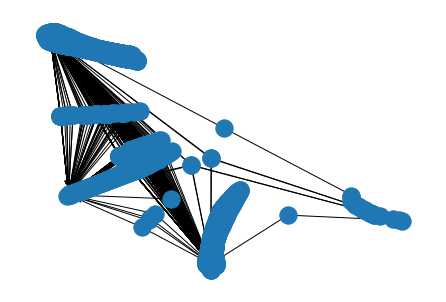

In [198]:
nx.draw(G)

In [ ]:
G2 = nx.from_pandas_edgelist(df=graph_data.iloc[0,'bg_appearances'], source='CleanJobTitle',
                            target='bg_appearances',
#                             edge_attr='CanonYearsOfExperienceLevel',
                            create_using=nx.DiGraph)

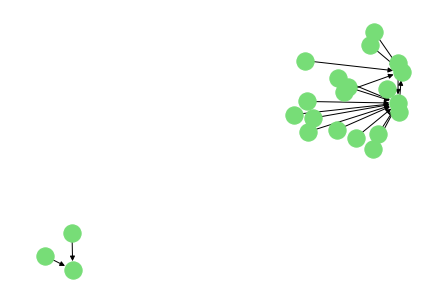

In [206]:
nx.draw(G2, node_color='#77DD77', with_labels=False)

In [249]:
from typing import Tuple
S = nx.DiGraph()

In [250]:
for i, j in zip(graph_data['BGTSubOcc'].values[:150], graph_data['bg_appearances'].values[:150]):
    if i != np.nan and j != []:
#         S.add_node(i)
        for m in j:
            S.add_edges_from([(i, m)])

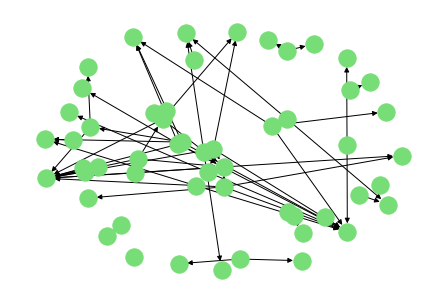

In [253]:
nx.draw(S, node_color='#77DD77', with_labels=False)

In [ ]:
for i in graph_data['BGTSubOcc']:
    print(i)

Next step --> Add weighted edges for those positions that appear most frequently.

## Algorithm

1. Model 1: classification based on job cat (low, mid, high) (output - input)
2. Model 2.1: split each classiffication, split on key words and assign new labels, predict sub-divisions. (output - input)
2. Model 2.2: Agglomerative clustering of each class (this and 2.1 could be tested in different orders) (output - input)
3. Model 3: DBSCAN (output - \[optional input])
4. Model 4: KNN or Naive bayes to generalise to new data (input)
5. Network graph for a given company. Show relationships.

In [217]:
sum(df['CanonYearsOfExperienceLevel'].isnull()) / len(df) * 100

36.499322707333

In [315]:
labels_mask = df['CanonYearsOfExperienceLevel'].notnull()

In [316]:
df_levels = df.loc[labels_mask, :].copy()
df_levels.shape

(456126, 58)

In [317]:
df_levels.head()

,index,BGTOcc,BGTSubOcc,CIPCode,CanonCertification,CanonCity,CanonCountry,CanonCounty,CanonEmployer,CanonIntermediary,CanonJobHours,CanonJobTitle,CanonJobType,CanonMaximumDegree,CanonMinimumDegree,CanonOtherDegrees,CanonPostalCode,CanonPreferredDegrees,CanonRequiredDegrees,CanonSkillClusters,CanonSkills,CanonState,CanonYearsOfExperienceCanonLevel,CanonYearsOfExperienceLevel,CleanJobTitle,ConsolidatedDegreeLevels,ConsolidatedInferredNAICS,ConsolidatedONET,ConsolidatedTitle,DivisionCode,Email,InternshipFlag,IsDuplicate,IsDuplicateOf,JobDate,JobDomain,JobID,JobReferenceID,JobText,JobURL,LMA,Language,Latitude,Longitude,MSA,MaxAnnualSalary,MaxDegreeLevel,MaxExperience,MaxHourlySalary,MinAnnualSalary,MinDegreeLevel,MinExperience,MinHourlySalary,PostingHTML,Source,StandardMajor,Telephone,YearsOfExperience
8,8,49-3023.00,Automotive Service Technician / Mechanic,NaN,\n,Arcadia,USA,DeSoto,Chrysler,NaN,NaN,Auto Mechanic,NaN,NaN,NaN,NaN,34265,NaN,NaN,"Maintenance, Repair, and Installation: Vehicle...","{'Auto Repair': 'Maintenance, Repair, and Inst...",FL,1-6,mid,Automotive Automotive Mechanic/Auto Technician...,NaN,336111.0,49302302,Auto Mechanic,NaN,NaN,0,False,NaN,2017-03-19,automotive.jobs.net,38198249176,NaN,Automotive Mechanic / Auto Technician\n\nDesot...,http://automotive.jobs.net/j/automotive-automo...,MC121158,en,27.1877,-81.8075,11580: Micropolitan Statistical Area,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,Job Board,NaN,NaN,2 years
12,12,49-3023.00,Automotive Service Technician / Mechanic,NaN,\n,Saint Helens,USA,Columbia,Chrysler,NaN,fulltime,Auto Technician,permanent,NaN,NaN,NaN,97051,NaN,NaN,"Maintenance, Repair, and Installation: Vehicle...","{'Auto Repair': 'Maintenance, Repair, and Inst...",OR,1-6,mid,Automotive Technician,NaN,336111.0,49302302,Auto Technician,NaN,NaN,0,False,NaN,2017-03-22,www.careerbuilder.com,38199653899,0951P,Automotive Technician\n\nChrysler Dealer Sain...,http://www.careerbuilder.com/job/J8G7XW78V8HLG...,MT413890,en,45.8609,-122.8310,38900: Metropolitan Statistical Area,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,Job Board,NaN,NaN,At least 2 year|At least two years
13,13,49-3023.00,Automotive Service Technician / Mechanic,NaN,\n,Miami,USA,Saline,Chrysler,NaN,fulltime,Automotive Service Advisor,permanent,NaN,Higher Secondary Certificate,NaN,65344,NaN,Higher Secondary Certificate,Specialized Skills|Customer and Client Support...,{'Automotive Services Industry Knowledge': 'Sp...,MO,0-1,low,Automotive Service Advisor,12,336111.0,49302302,Automotive Service Advisor,NaN,NaN,0,False,NaN,2017-03-22,www.careers.org,38199585338,NaN,EXPERIENCED Automotive Service Advisor needed\...,http://www.careers.org/jobs/job/J5L0LR6VJTK3SB...,MC293218,en,39.3217,-93.2271,32180: Micropolitan Statistical Area,NaN,NaN,NaN,NaN,NaN,12.0,1.0,NaN,NaN,Job Board,NaN,NaN,At least 1 year|One year
14,14,41-4011.00,Business Development Specialist,NaN,NaN,Saint Helens,USA,Columbia,Chrysler,NaN,fulltime,Sales Representative,permanent,NaN,NaN,NaN,97051,NaN,NaN,Administration: Administrative Support;Special...,{'Administrative Functions': 'Administration: ...,OR,1-6,mid,Sales Representative,NaN,336111.0,41401200,Sales Representative,NaN,NaN,0,False,NaN,2017-03-22,www.careerbuilder.com,38199655315,0951P,Experienced Sales Rep\n\nChrysler Dealer Sales...,http://www.careerbuilder.com/job/JHT0N779Q6QN7...,MT413890,en,45.8609,-122.8310,38900: Metropolitan Statistical Area,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,Job Board,NaN,NaN,At least 2 year
15,15,49-3023.00,Automotive Service Technician / Mechanic,NaN,\n,Saukville,USA,Ozaukee,Chrysler,NaN,fulltime,Auto Technician,permanent,NaN,Higher Secondary Certificate,NaN,53080,NaN,Higher Secondary Certificate,"Maintenance, Repair, and Installation: Vehicle...","{'Auto Repair': 'Maintenance, Repair, and Inst...",WI,1-6,mid,Certified Automotive Technician,12,336111.0,49302302,Auto Technician,NaN,NaN,0,False,NaN,2017-03-19,www.careerbuilder.com,38198403646,0622p,Chrysler Certified Automotive Technician\n\nCh...,http://www.c

About a third of the dataset does not have level data.

In [318]:
len(df) * (sum(df['CanonYearsOfExperienceLevel'].isnull()) / len(df))

262175.0

In [319]:
print(sum(df_levels['StandardMajor'].isnull()))
print(df_levels['StandardMajor'].unique())

301349
[nan 'Engineering, General|Mechanical Engineering'
 'Accounting|Business Administration And Management, General' ...
 'Business Administration And Management, General|Computer Science|Economics, General|Finance, General|Management Information Systems, General|Mathematics, General'
 'Business Administration And Management, General|Pre-Law Studies'
 'Accounting|Computer Science|Finance, General|Management Information Systems, General|Mathematics, General|Statistics, General']


In [320]:
df_levels.drop(labels=['index', 'CanonCertification', 'CIPCode',
                       'CanonCity', 'CanonCountry', 'CanonCounty',
                       'CanonIntermediary', 'CanonOtherDegrees',
                       'CanonPreferredDegrees', 'CanonRequiredDegrees',
                       'ConsolidatedDegreeLevels', 'DivisionCode', 'Email',
                       'InternshipFlag', 'IsDuplicate', 'IsDuplicateOf',
                       'JobDomain', 'JobID', 'JobReferenceID',
                       'Language', 'Latitude', 'Longitude', 
                       'MaxAnnualSalary', 'MaxDegreeLevel', 'MaxExperience',
                       'MaxHourlySalary', 'MinAnnualSalary',
                       'PostingHTML', 'Source', 'Telephone', 'CanonPostalCode',
                       'BGTOcc', 'BGTSubOcc', 'CanonJobTitle',
                       'CanonMaximumDegree', 'CanonMinimumDegree',
                       'CanonYearsOfExperienceCanonLevel', 'ConsolidatedTitle',
                       'JobDate', 'JobURL', 'CleanJobTitle', 'MinHourlySalary',
                       'StandardMajor', 'YearsOfExperience', ],
                        axis=1, inplace=True)

In [321]:
df_levels.head()

,CanonEmployer,CanonJobHours,CanonJobType,CanonSkillClusters,CanonSkills,CanonState,CanonYearsOfExperienceLevel,ConsolidatedInferredNAICS,ConsolidatedONET,JobText,LMA,MSA,MinDegreeLevel,MinExperience
8,Chrysler,NaN,NaN,"Maintenance, Repair, and Installation: Vehicle...","{'Auto Repair': 'Maintenance, Repair, and Inst...",FL,mid,336111.0,49302302,Automotive Mechanic / Auto Technician\n\nDesot...,MC121158,11580: Micropolitan Statistical Area,NaN,2.0
12,Chrysler,fulltime,permanent,"Maintenance, Repair, and Installation: Vehicle...","{'Auto Repair': 'Maintenance, Repair, and Inst...",OR,mid,336111.0,49302302,Automotive Technician\n\nChrysler Dealer Sain...,MT413890,38900: Metropolitan Statistical Area,NaN,2.0
13,Chrysler,fulltime,permanent,Specialized Skills|Customer and Client Support...,{'Automotive Services Industry Knowledge': 'Sp...,MO,low,336111.0,49302302,EXPERIENCED Automotive Service Advisor needed\...,MC293218,32180: Micropolitan Statistical Area,12.0,1.0
14,Chrysler,fulltime,permanent,Administration: Administrative Support;Special...,{'Administrative Functions': 'Administration: ...,OR,mid,336111.0,41401200,Experienced Sales Rep\n\nChrysler Dealer Sales...,MT413890,38900: Metropolitan Statistical Area,NaN,2.0
15,Chrysler,fulltime,permanent,"Maintenance, Repair, and Installation: Vehicle...","{'Auto Repair': 'Maintenance, Repair, and Inst...",WI,mid,336111.0,49302302,Chrysler Certified Automotive Technician\n\nCh...,MT553334,33340: Metropolitan Statistical Area,12.0,3.0


In [ ]:
data_dummies = 

In [300]:
import seaborn as sns
sns.set(style="ticks", palette="pastel")

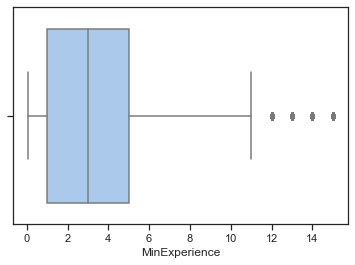

In [301]:
sns.boxplot(x=df_levels['MinExperience'])

In [ ]:
sns.distplot(df_levels['MinExperience'])

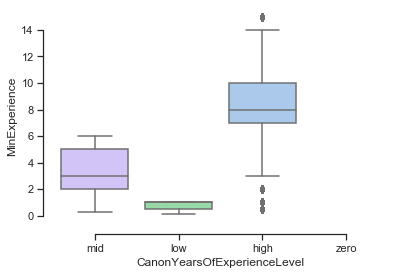

In [305]:
sns.boxplot(x="CanonYearsOfExperienceLevel", y="MinExperience",
            #hue="smoker",
            palette=["m", "g", "b"],
            data=df_levels)
sns.despine(offset=10, trim=True)

For MinExperience use ffill with either mean or median